In [12]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from tf_keras.models import Sequential
from tf_keras.layers import Dense
from sklearn.metrics import r2_score

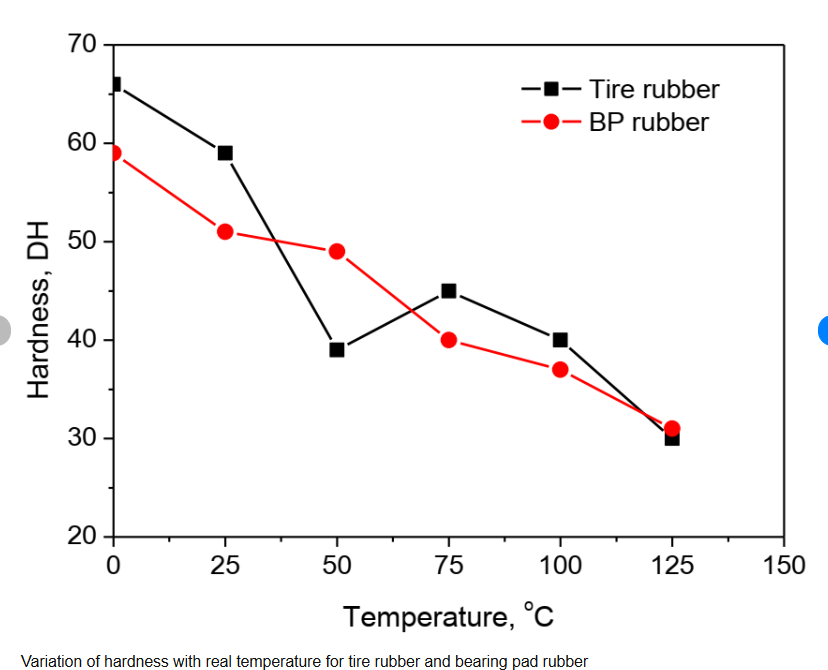
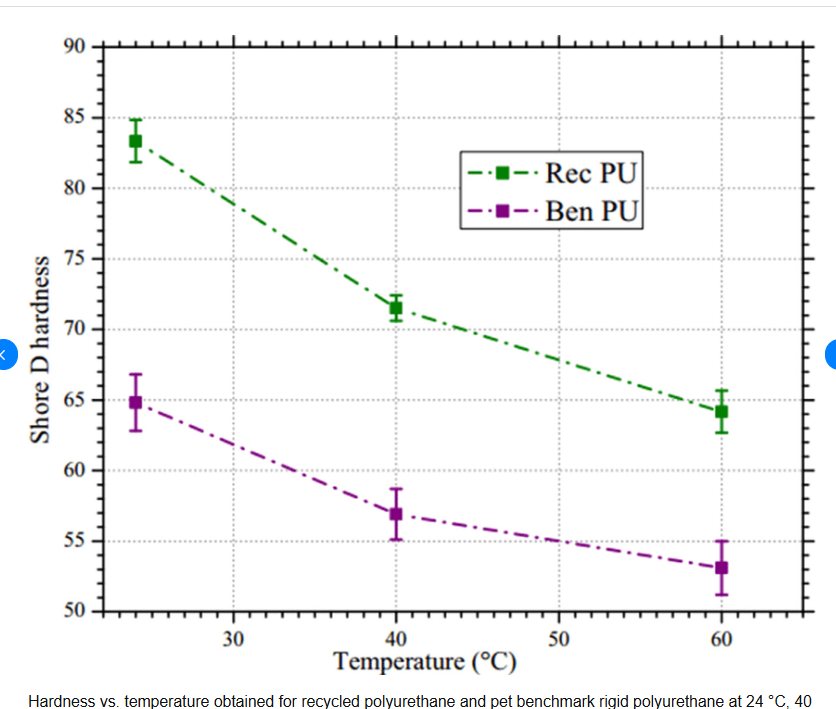
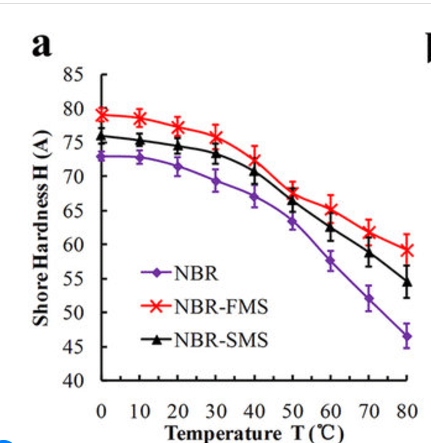

In [2]:
slope = (65-30)/(0-125)
# hardness at 23deg C
H_C1 = 85
H_C2 = 80
H_C3 = 75
H_C4 = 70
H_C5 = 65
shoreA_H = np.array([H_C1, H_C2, H_C3, H_C4, H_C5])
shoreA_H[0]

85

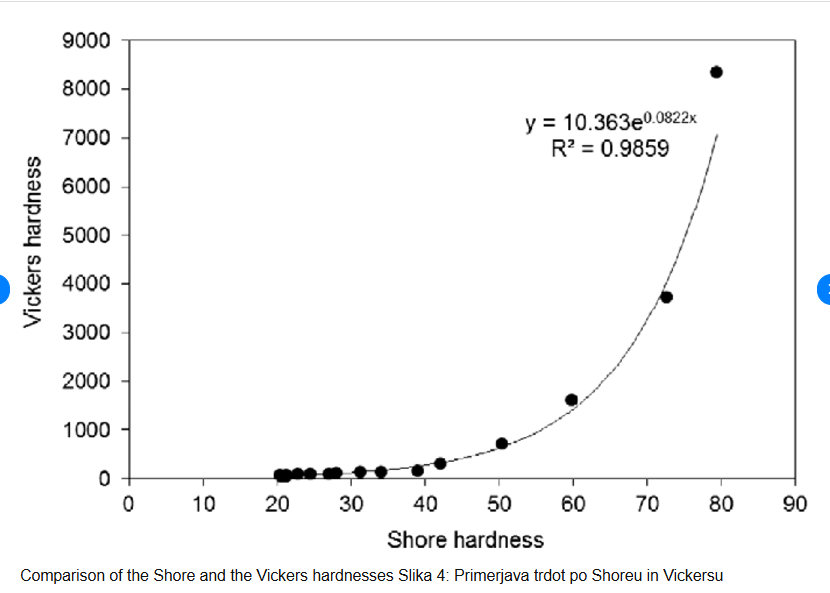
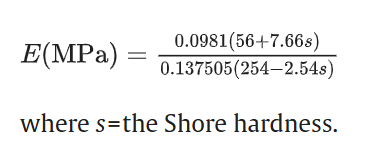


In [4]:
file_path = r"C:\Users\deban\Desktop\Imp Docs\RaceCar\Dataset\toFindK.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")  

In [5]:
# Tire temperatures
tire1 = df["front_surface_temp"].to_numpy()
tire2 = df["rear_surface_temp"].to_numpy()
tire3 = df["front_inner_temp"].to_numpy()
tire4 = df["rear_inner_temp"].to_numpy()

# Ext factors
humidity1 = df["Humidity"].to_numpy()
temp_surr1 = df["Ambient_Temperature"].to_numpy()
surface_rougness1 = df["Surface_Roughness"].to_numpy()

# Car specific factors
force1 = df["force_on_tire"].to_numpy()
tire_type1 = df["Tire_Compound"].to_numpy()  # find E and H using this
fric_coeff1 = df["Tire_Friction_Coefficient"]
v1 = df["Speed"].to_numpy()
t1 = df["Tire_wear"].to_numpy() # in grams density in 1.1 g/cc

time1 = df["lap_time"]

n = np.size(tire_type1)

H1 = np.zeros(n)
H2 = np.zeros(n)
H3 = np.zeros(n)
H4 = np.zeros(n)
H1_v = np.zeros(n)
H2_v = np.zeros(n)
H3_v = np.zeros(n)
H4_v = np.zeros(n)
E1 = np.zeros(n)
E2 = np.zeros(n)
E3 = np.zeros(n)
E4 = np.zeros(n)

# Create a dictionary to map tire types to their corresponding Shore A hardness
tire_hardness_map = {'C1': shoreA_H[0], 'C2': shoreA_H[1], 'C3': shoreA_H[2], 'C4': shoreA_H[3], 'C5': shoreA_H[4]}

# Vectorized loop for efficient computation
for i in range(n):
    H0 = tire_hardness_map[tire_type1[i]]  # Get the base hardness for the current tire type
    temp_diff = np.array([tire1[i], tire2[i], tire3[i], tire4[i]]) - 23  # Calculate temperature differences
    hardness_adjustments = H0 + slope * temp_diff  # Compute adjusted hardness values
    H1[i], H2[i], H3[i], H4[i] = hardness_adjustments  # shore A hardness of each tire
    hardness_vickers = 10.363 * np.exp(0.0822 * hardness_adjustments) 
    H1_v[i],H2_v[i],H3_v[i],H4_v[i] = hardness_vickers # vickers hardness of each tire
    Emodulus = (0.0981*(56 + 7.66 * hardness_adjustments)) / (0.137505 * (254 - 2.54*hardness_adjustments))
    E1[i], E2[i], E3[i], E4[i] = Emodulus # elastic modulus of each tire

In [6]:
H_v = np.zeros(n)
E = np.zeros(n)
# wear coefficient
K = np.zeros(n)
#R = 350 #mm
#d = 300 #mm
for i in range(n):
    H_v[i] = np.max([H1_v[i],H2_v[i],H3_v[i],H4_v[i]])
    E[i] = np.max([E1[i], E2[i], E3[i], E4[i]])
E = E * 10**(6)    
W0 = t1[0]/1.1 #cm^3, we get volume in cc
W0 = W0* 10**(-6) #m^3
K[0] = W0 * H_v[0]/ (force1[0] * v1[0] * 0.27777778  * 1)
for i in range(1, n):
    time_diff = time1[i] - time1[i-1]
    if force1[i] != 0 and v1[i] != 0 and time_diff != 0:
        W = t1[i] / 1.1
        W = W * 10**(-6)
        K[i] = W * H_v[i] / (force1[i] * v1[i] * 0.27777778 * time_diff)
    else:
        K[i] = 0  # or handle this case in a way that makes sense for your application
K

array([7.09449127e-10, 6.35792296e-10, 7.01547389e-10, ...,
       1.29017485e-10, 1.11920671e-10, 8.84328600e-11])

In [ ]:
# Encode tire type (OneHotEncoding)
encoder = OneHotEncoder(sparse_output=False)
tire_type_encoded1 = encoder.fit_transform(tire_type1.reshape(-1, 1))

# Combine inputs
inputs1 = np.column_stack([
    tire1, tire2, tire3, tire4,
    humidity1, temp_surr1, surface_rougness1,
    force1, fric_coeff1.to_numpy(), v1, t1,
    tire_type_encoded1, E
])
# Scale features and targets
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(inputs1, K, test_size=0.2, random_state=42)

X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1)).flatten()


MSE: 0.20481861928891124
RMSE: 0.45256891109411307
R²: 0.7934470144907161
MAPE: 290.38246083506965


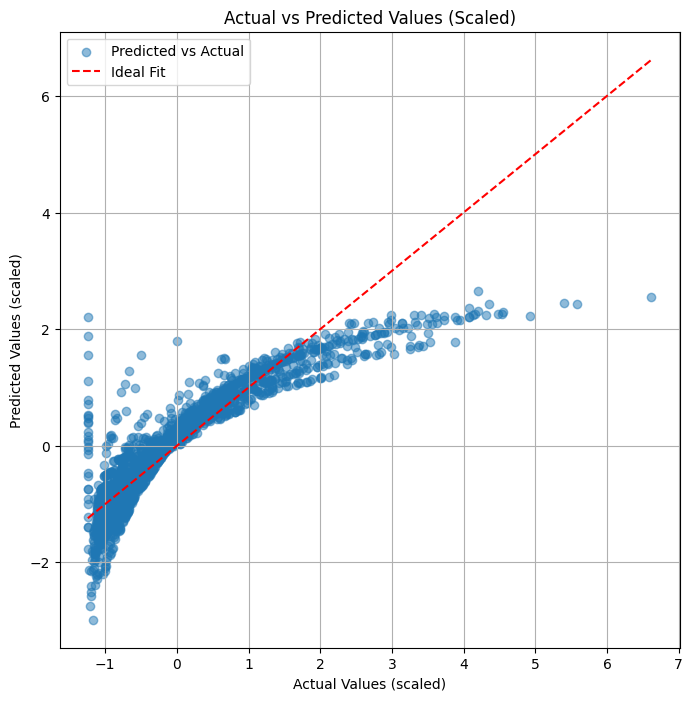

In [10]:
# Train the linear regression model on scaled data
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train_scaled)

# Make predictions on validation set (scaled)
y_pred1 = linear_model.predict(X_val_scaled)

# Calculate metrics (all on scaled data)
mse = mean_squared_error(y_val_scaled, y_pred1)
rmse = np.sqrt(mse)
r2 = r2_score(y_val_scaled, y_pred1)
epsilon = 1e-10  # To handle division by zero in MAPE calculation
y_val_scaled_safe = np.where(y_val_scaled == 0, epsilon, y_val_scaled)
mape = np.mean(np.abs((y_val_scaled - y_pred1) / y_val_scaled_safe)) * 100

# Print metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

# Plot Actual vs Predicted (scaled)
plt.figure(figsize=(8, 8))
plt.scatter(y_val_scaled, y_pred1, alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_val_scaled), max(y_val_scaled)], [min(y_val_scaled), max(y_val_scaled)], color='red', linestyle='--', label="Ideal Fit")
plt.xlabel("Actual Values (scaled)")
plt.ylabel("Predicted Values (scaled)")
plt.title("Actual vs Predicted Values (Scaled)")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(128, activation='linear'),
    Dense(256, activation='tanh'),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
# Update your training to use scaled targets
history = model.fit(
    X_train_scaled, y_train_scaled, 
    epochs=100, batch_size=32, 
    validation_data=(X_val_scaled, y_val_scaled),
    verbose=1
)

# Make predictions and evaluate (single call)
y_pred_scaled2 = model.predict(X_val_scaled)
y_pred2 = scaler_y.inverse_transform(y_pred_scaled2)


Epoch 1/100
303/303 [==============================] - 2s 3ms/step - loss: 0.1750 - mae: 0.2449 - val_loss: 0.1561 - val_mae: 0.2410
Epoch 2/100
303/303 [==============================] - 1s 3ms/step - loss: 0.1371 - mae: 0.2055 - val_loss: 0.1175 - val_mae: 0.1914
Epoch 3/100
303/303 [==============================] - 1s 3ms/step - loss: 0.1158 - mae: 0.1836 - val_loss: 0.1055 - val_mae: 0.1549
Epoch 4/100
303/303 [==============================] - 1s 3ms/step - loss: 0.1019 - mae: 0.1678 - val_loss: 0.1066 - val_mae: 0.1879
Epoch 5/100
303/303 [==============================] - 1s 3ms/step - loss: 0.1008 - mae: 0.1673 - val_loss: 0.0847 - val_mae: 0.1358
Epoch 6/100
303/303 [==============================] - 1s 3ms/step - loss: 0.0831 - mae: 0.1478 - val_loss: 0.0905 - val_mae: 0.1594
Epoch 7/100
303/303 [==============================] - 1s 3ms/step - loss: 0.0813 - mae: 0.1482 - val_loss: 0.0956 - val_mae: 0.1553
Epoch 8/100
303/303 [==============================] - 1s 3ms/step - 

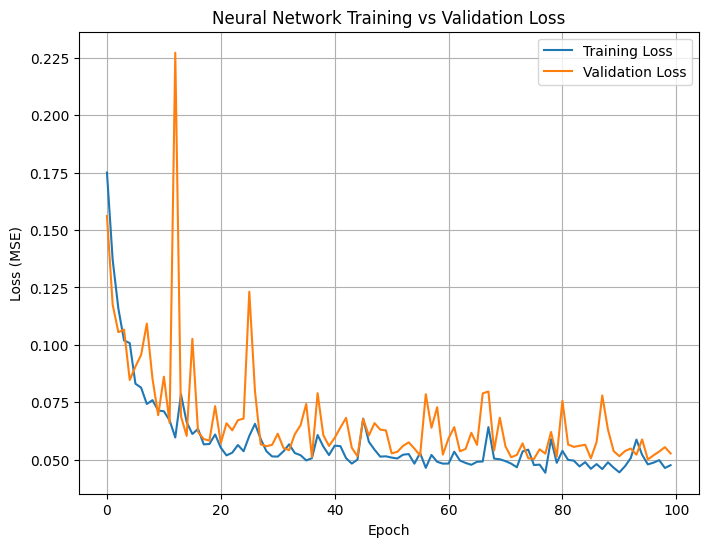

In [26]:
# Plot training vs validation loss for the neural network
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Neural Network Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

MSE (NN): 0.052701174372166336
RMSE (NN): 0.22956736347348317
R² (NN): 0.9468525618217286
MAPE (NN, unscaled): 10.215976695388678


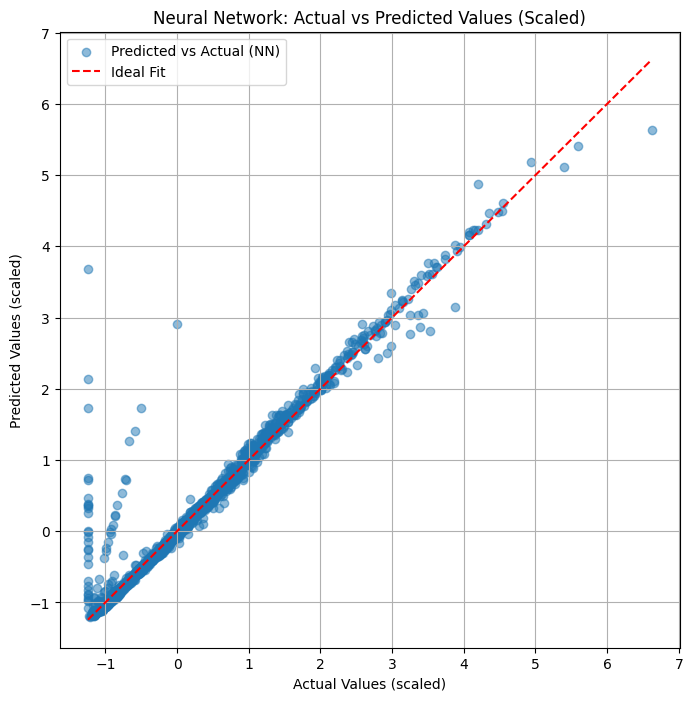

In [27]:
# Calculate metrics for the neural network predictions
mse_nn = mean_squared_error(y_val_scaled, y_pred_scaled2)
rmse_nn = np.sqrt(mse_nn)
r2_nn = r2_score(y_val_scaled, y_pred_scaled2)
y_val_scaled_safe_nn = np.where(y_val_scaled == 0, epsilon, y_val_scaled)
mape_nn = np.mean(np.abs((y_val_scaled - y_pred_scaled2) / y_val_scaled_safe_nn)) * 100

print(f"MSE (NN): {mse_nn}")
print(f"RMSE (NN): {rmse_nn}")
print(f"R² (NN): {r2_nn}")
# Inverse transform to original units
y_val_orig = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_pred_orig = scaler_y.inverse_transform(y_pred_scaled2).flatten()

# Avoid division by zero
epsilon = 1e-10
y_val_safe = np.where(y_val_orig == 0, epsilon, y_val_orig)

# Correct MAPE calculation on unscaled values
mape_nn = np.mean(np.abs((y_val_orig - y_pred_orig) / y_val_safe)) * 100

print(f"MAPE (NN, unscaled): {mape_nn}")

# Plot Actual vs Predicted (scaled) for Neural Network
plt.figure(figsize=(8, 8))
plt.scatter(y_val_scaled, y_pred_scaled2, alpha=0.5, label="Predicted vs Actual (NN)")
plt.plot([min(y_val_scaled), max(y_val_scaled)], [min(y_val_scaled), max(y_val_scaled)], color='red', linestyle='--', label="Ideal Fit")
plt.xlabel("Actual Values (scaled)")
plt.ylabel("Predicted Values (scaled)")
plt.title("Neural Network: Actual vs Predicted Values (Scaled)")
plt.legend()
plt.grid(True)
plt.show()


In [36]:
import joblib

# Save the trained Keras model (use .keras format for best compatibility)
model.save('k_predictor_model.keras')

# Save the feature scaler (for input preprocessing)
joblib.dump(scaler_X, 'feature_scaler.pkl')

# Save the target scaler (for output postprocessing)  
joblib.dump(scaler_y, 'target_scaler.pkl')

print("Model and scalers saved successfully!")


Model and scalers saved successfully!
